## Plot the redshift erros distribution

1. Plot the redshift errors distribution for all tracers
2. Study the Z-dependece, especailly for QSO
3. The variance of the repeats samples

In [2]:
import os, sys
import random
import fitsio
import numpy as np
from astropy.table import Table,join,unique,vstack
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_OVERALL, COLOR_OVERALL
from helper import REDSHIFT_VSMEAR, REDSHIFT_LSS_VSMEAR, REDSHIFT_CUBICBOX, COLOR_TRACERS, GET_RECON_BIAS
%load_ext autoreload
%autoreload 2

Z_SMEAR = REDSHIFT_VSMEAR

# save the figure to the overleaf or not
save_fig = True

OVERLEAF_DIR = '/global/homes/s/shengyu/desi_y3_redshift_errors/overleaf/figures'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'
RESULT_DIR = '/global/homes/s/shengyu/desi_y3_redshift_errors/main/repeat_obs/results'

In [3]:
def generate_dv(tracer, zmin, zmax):
    c = 299792.458
    d = Table.read(f'{REPEAT_DIR}/{tracer}repeats.fits', hdu=1)
    sel      = np.full(len(d),True)
    sel = np.isfinite(d['Z1']) & np.isfinite(d['Z2'])
    selz = ((zmin<d["Z1"])&(d["Z1"]<zmax))
    # d_zbin = d[sel]
    d_zbin = d[sel & selz]
    dv_zbin = (d_zbin['Z2']-d_zbin['Z1'])/(1+d_zbin['Z1'])*c
    return dv_zbin

def get_cthr(tracer):
    if tracer in ['BGS', 'LRG', 'ELG']:
        cthr = 1000
    elif tracer in ['QSO']:
        cthr = 10000
    elif tracer in ['QSO_3cut']:
        cthr = 3000
    return cthr

BGS z (0.1, 0.4) Median:13.32 RMS:35.99 fc:0.51%
LRG z (0.4, 1.1) Median:40.68 RMS:82.12 fc:0.46%
ELG z (0.8, 1.6) Median:8.58 RMS:28.16 fc:0.23%


/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


QSO z (0.8, 2.1) Median:90.96 RMS:471.24 fc:0.61%


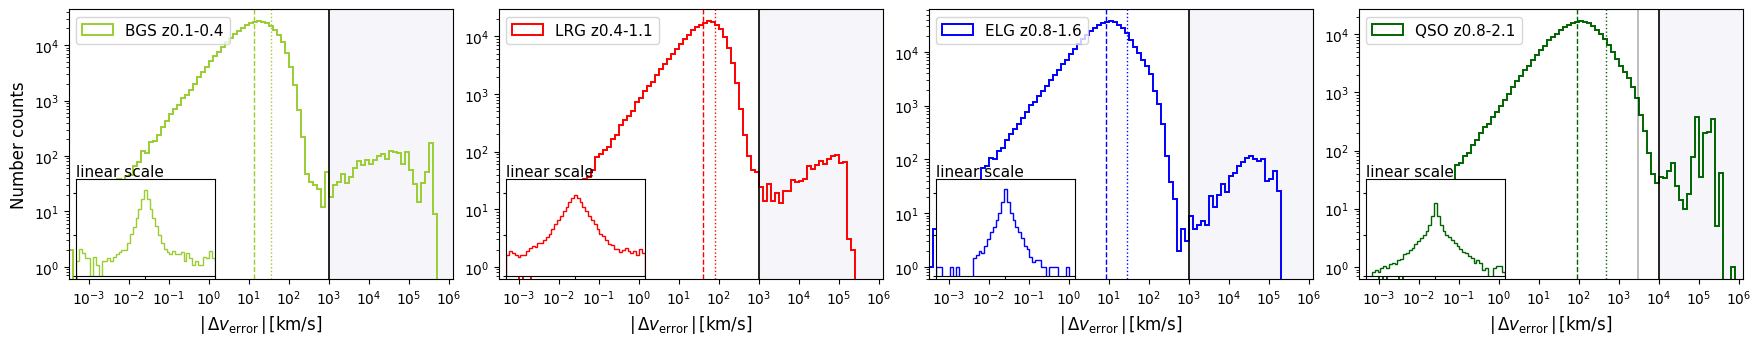

In [4]:
# plot the overall dv distribution
fig = plt.figure(figsize=(18, 3))
gs = gridspec.GridSpec(1,4,wspace=0.12,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)

tracers = ['BGS', 'LRG', 'ELG', 'QSO']
for idx, tracer in enumerate(tracers):
    (zmin, zmax) = REDSHIFT_OVERALL[tracer[:3]]
    color = COLOR_OVERALL[tracer[:3]]
    ax = plt.subplot(gs[idx])
    dv = generate_dv(tracer[:3], zmin, zmax)
    # ===== quantities of dv =====
    cthr = get_cthr(tracer)
    dv_smear = dv[abs(dv) < cthr]
    median_dv = np.median(abs(dv))
    RMS = np.sqrt(np.mean(dv_smear**2))
    fc= np.mean(abs(dv) >= cthr)*100 # fc = (np.sum(abs(dv) > cthr)) /len(dv)*100
    print(tracer, 'z',(zmin, zmax), f'Median:{median_dv:.2f}', f'RMS:{RMS:.2f}', f'fc:{fc:.2f}%')
    # ===== main panel (log10 |dv|) =====
    catasmin, catasmax, catasbin = -3.5, 6.1, 0.1
    ax.hist(np.log10(abs(dv)), histtype='step', bins=np.arange(catasmin, catasmax, catasbin), 
            label = f'{tracer[:3]} z{zmin}-{zmax}', lw = 1.4, color= color)
    ax.axvline(x=np.log10(median_dv), color=color, linestyle='--', linewidth=1.0) # Median of dv
    ax.axvline(x=np.log10(RMS), color=color, linestyle=':', linewidth=1.0) # RMS of dv
    ax.axvline(x=4 if tracer == 'QSO' else 3, color='black', linestyle='-', linewidth=1.2) # catastrophic therehold
    if tracer == 'QSO':
        ax.axvline(x=np.log10(3000), color='black', linestyle='-', linewidth=1.2, alpha=0.3)    
    ax.axvspan(4 if tracer == 'QSO' else 3, 7, color='darkblue', alpha=0.04, zorder=0)
    # plot axes settings
    ax.legend(loc=2, fontsize = 11)
    ax.set_xlabel(r'$| \, \Delta v_{\mathrm{error}} \, | \, \rm{[km/s]}$', fontsize=12)
    ax.set_yscale('log')
    if idx == 0:
        ax.set_ylabel(r'Number counts', fontsize = 12)
    ax.set_xlim(catasmin, catasmax)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: fr"$10^{{{int(x)}}}$"))
    # ===== inset panel (linear |dv|) =====
    # position: [left, bottom, width, height] in axes fraction
    ax_in = inset_axes(ax, width="80%", height="80%", loc="upper left",
                       bbox_to_anchor=(0.02, -0.08, 0.45, 0.45), bbox_transform=ax.transAxes, borderpad=0)
    bins = np.linspace(-cthr, cthr, 50)
    ax_in.hist(dv_smear, bins = bins, histtype='step', lw=1.0, color=color, density=True)
    # cosmetics for inset
    ax_in.set_xlim(-cthr, cthr)
    ax_in.set_yscale('log')  # set the log scale
    ax_in.set_ylim(10**(-8), 10**(-1))
    ax_in.tick_params(axis='both', which='both', labelsize=11, length=2)
    # keep inset clean: no labels, maybe a tiny note
    ax_in.set_xticklabels([])
    ax_in.set_yticklabels([])
    ax_in.set_title('linear scale', fontsize=11, pad=2, loc='left')
    for spine in ['top','right','left','bottom']:
        ax_in.spines[spine].set_linewidth(0.8)
        
if save_fig == True:
    plt.savefig(OVERLEAF_DIR+f'/hist_model_redshift_errors', dpi=300, bbox_inches='tight')

## Z-dependence and QSO smearing  

/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)
/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


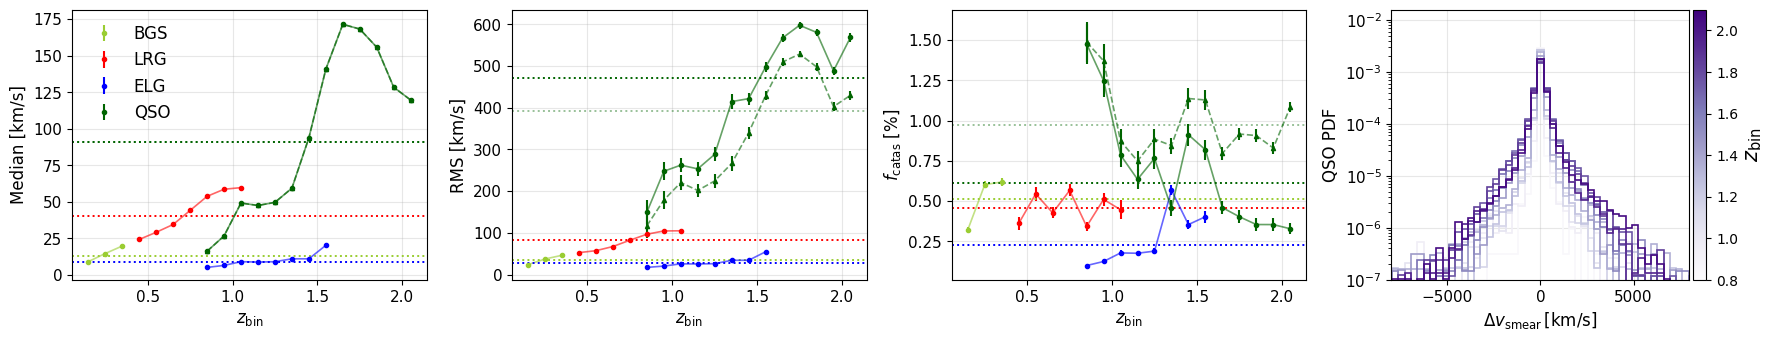

In [5]:
tracers = ['BGS','LRG', 'ELG', 'QSO', 'QSO_3cut']
step = 0.1

var_method = 'bootstrap' # bootstrap, jackknife
metrics_fn = RESULT_DIR+f'/repeat_metrics_{var_method}.csv'
metrics_tab = Table.read(metrics_fn, format="csv")

overall_values = {
    'BGS': [13.3, 36.0, 0.51],
    'LRG': [40.7, 82.1, 0.46],
    'ELG': [8.6, 28.2, 0.23],
    'QSO': [91.0, 471.2, 0.61],
    'QSO_3cut': [91.0, 391.0, 0.97]
} # med_mean, rms_mean, fc_mean

markers = ['o', 's', '^', 'D', 'v', '*', 'x', 'P']
fig = plt.figure(figsize=(18, 3))
gs = gridspec.GridSpec(1,4,width_ratios=[1, 1, 1, 1],
                       wspace=0.24,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)
for idxt, tracer in enumerate(tracers):
    (zmin, zmax) = REDSHIFT_OVERALL[tracer[:3]]
    zrange = np.round(np.arange(zmin, zmax+ step/2, step), 1)
    zbins = list(zip(zrange[:-1], zrange[1:]))
    color = COLOR_OVERALL[tracer[:3]]
    marker = markers[idxt]
    zmid_list, median_list, rms_list, fc_list = [], [], [], []
    for indz, (z1, z2) in enumerate(zbins):
        dv = generate_dv(tracer[:3], z1, z2)
        # ===== quantities of dv =====
        cthr = get_cthr(tracer)
        dv_smear = dv[abs(dv) < cthr]
        median_dv = np.median(abs(dv))
        RMS = np.sqrt(np.mean(dv_smear**2))    
        fc= np.mean(abs(dv) >= cthr)*100 # fc = (np.sum(abs(dv) > cthr)) /len(dv)*100
        var = metrics_tab[metrics_tab["tracer"] == f"{tracer[:3]}_z{z1}_{z2}"]
        zmid_list.append((z1 + z2) / 2)
        median_list.append((median_dv, var['med_std'][0])) # in km/s
        rms_list.append((RMS, var['rms_std'][0])) # in km/s
        fc_list.append((fc, var['fc_std'][0])) # in %
    # === Plot panels ===
    metric_lists = [median_list, rms_list, fc_list]
    qlabels = ['med_std', 'rms_std','fc_std']
    ylabels = [r"Median [km/s]", r"RMS [km/s]", r"$f_{\mathrm{catas}}$ [%]"]
    for idxq, (vals, ylabel) in enumerate(zip(metric_lists, ylabels)):
        means, errs = zip(*vals)            # unzip -> two tuples
        ax = plt.subplot(gs[idxq])
        # ax.scatter(zmid_list, means, color=color, s=30, label=tracer)
        ax.errorbar(zmid_list, means, yerr = errs, label = tracer, 
                    marker= '^' if tracer == 'QSO_3cut' else 'o', markersize=3, 
                    color = color, linestyle='none',)
        if idxt == 4:
            ax.plot(zmid_list, means, color=color, lw=1.2, alpha=0.6, ls='--')
        else:
            ax.plot(zmid_list, means, color=color, lw=1.2, alpha=0.6)
        # === add horizontal line for global value ===
        yvalue = overall_values[tracer][idxq]
        yvar = metrics_tab[metrics_tab["tracer"] == f"{tracer[:3]}_z{zmin}_{zmax}"][qlabels[idxq]][0]
        ax.axhline(y=yvalue, color=color, linestyle=':', lw=1.4, alpha=0.4 if tracer == 'QSO_3cut' else 1.0)
        # ax.axhspan(yvalue-yvar, yvalue+yvar, color=color, alpha=0.3)
        # plot axes settings
        ax.set_xlabel(r"$z_{\mathrm{bin}}$", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(alpha=0.3)
        if idxq==0 and idxt==3:
            ax.legend(fontsize=12, loc='best', frameon=False)
    # ===== 4th panel — QSO: PDF of v_smear vs z =====
    tracerh = 'QSO'
    if tracer == tracerh:
        axh = plt.subplot(gs[3])
        # build z bins
        z_edges = zrange
        z_mids  = 0.5 * (z_edges[:-1] + z_edges[1:])
        n_z     = len(zbins)
        # linear dv bins
        cthr = 10000 if tracerh == 'QSO' else 1000
        dv_edges = np.linspace(-cthr, cthr, 60)
        dv_centers = 0.5 * (dv_edges[:-1] + dv_edges[1:])
        # colormap to encode redshift
        cmap = plt.cm.Purples
        norm = plt.Normalize(vmin=z_edges[0], vmax=z_edges[-1])
        for (z1, z2), zmid in zip(zbins, z_mids):
            dv = generate_dv('QSO', z1, z2)
            dv_smear = dv[abs(dv) < cthr]
            # counts, _ = np.histogram(dv_smear, bins=dv_edges, density=True)
            # axh.plot(
            #     dv_centers, counts,
            #     color=cmap(norm(zmid)), lw=1.2,
            #     label=f"{zmid:.1f}" if zmid in z_mids[::3] else None  # fewer labels
            # )
            axh.hist(
                dv_smear, bins=dv_edges, 
                histtype='step', density=True,
                color=cmap(norm(zmid)), lw=1.2,
                label=f"{zmid:.1f}" if zmid in z_mids[::3] else None  # fewer labels
            )
        # plot axes settings
        axh.set_xlabel(r"$ \Delta v_{\mathrm{smear}} \, [\mathrm{km/s}]$", fontsize=12)
        axh.set_ylabel(r"QSO PDF", fontsize=12)
        axh.set_yscale('log')   # log-y usually helps span the tail
        axh.set_xlim(-cthr+2000, cthr-2000)
        axh.tick_params(axis='both', labelsize=11)
        axh.grid(alpha=0.3)
        axh.set_ylim(10**(-7.), 10**(-1.8))
        # colorbar for redshift
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=axh, pad=0.01)
        cbar.set_label(r"$z_{\mathrm{bin}}$", fontsize=15)
if save_fig == True:
    plt.savefig(OVERLEAF_DIR+f'/scatter_z_dependence', dpi=300, bbox_inches='tight')

In [ ]:
np.shape(metric_lists)

(3, 13, 2)

In [ ]:
yvar = metrics_tab[metrics_tab["tracer"] == f"{tracer}_z{zmin}_{zmax}"][qlabels[idxq]][0]
yvar

0.03578135018882708

## Estimate the error bar for redshift errors -- variance from the sample

In [ ]:
metrics_fn = RESULT_DIR+'/repeat_metrics_bootstrap.csv'
tab = Table.read(metrics_fn, format="csv")
tab

tracer,N,method,med_mean,med_std,rms_mean,rms_std,fc_mean,fc_std
str12,int64,str9,float64,float64,float64,float64,float64,float64
BGS_z0.1_0.4,362943,bootstrap,13.314640484376786,0.03578135018882708,35.985254809828284,0.2620712695402629,0.5088953361822656,0.011830193631791901
BGS_z0.1_0.2,126256,bootstrap,9.14392219344107,0.03812884665071258,23.767254209835915,0.4165335010708489,0.3223609175009504,0.015799489502442903
BGS_z0.2_0.3,140779,bootstrap,14.724409712294419,0.06233752072737464,37.187873828232625,0.4470843239408317,0.6023625682807805,0.02057302899878659
BGS_z0.3_0.4,95908,bootstrap,19.8271390811229,0.10360144856326947,46.16314254032979,0.4925853592545755,0.6183008716686824,0.025222898388513666
LRG_z0.4_1.1,207651,bootstrap,40.68156425262109,0.12650232620801785,82.12174255301862,0.2774604783080315,0.4594247078029964,0.014740598993853264
LRG_z0.4_0.5,22137,bootstrap,24.35508523075833,0.22625781091984606,52.49262036844174,1.2316510825783054,0.3613859149839635,0.04073660814483661
LRG_z0.5_0.6,29570,bootstrap,29.226578055272494,0.22247704321329978,57.1658779317793,0.634125957887457,0.5444707473791005,0.042371754059203334
LRG_z0.6_0.7,35593,bootstrap,34.59033205628163,0.24866004597747052,67.13741702038308,0.5981861296134069,0.42705026269210233,0.03462485584213658
LRG_z0.7_0.8,40449,bootstrap,44.163253598444115,0.31483688212045957,82.24675859096558,0.616535732160851,0.5661450221266285,0.03729112418152568


In [ ]:
metrics_fn = RESULT_DIR+'/repeat_metrics_jackknife.csv'
tab = Table.read(metrics_fn, format="csv")
tab

tracer,N,method,med_mean,med_std,rms_mean,rms_std,fc_mean,fc_std
str12,int64,str9,float64,float64,float64,float64,float64,float64
BGS_z0.1_0.4,362943,jackknife,13.315496934863882,0.060362936440026084,35.987606704791276,0.26293980128394406,0.5091708615402418,0.01181420988848367
BGS_z0.1_0.2,126256,jackknife,9.1463886866531,0.044258571959233634,23.762202772423795,0.41774268813575827,0.3223609175009505,0.01595312506781737
BGS_z0.2_0.3,140779,jackknife,14.72511772654802,0.05762765719763061,37.19282811506368,0.4491982298024064,0.6023625682807806,0.020622894666594654
BGS_z0.3_0.4,95908,jackknife,19.82688853352877,0.3480694300551675,46.15293355160739,0.4892776263581538,0.6183008716686823,0.02531208877647946
LRG_z0.4_1.1,207651,jackknife,40.67553965577278,0.13022634403553585,82.12357045627142,0.2767220331484961,0.4594247078029965,0.014840252125890857
LRG_z0.4_0.5,22137,jackknife,24.337194978859856,0.3530326937068666,52.50988276574673,1.237436228893967,0.36138591498396355,0.0403320109994505
LRG_z0.5_0.6,29570,jackknife,29.22983139256377,0.22098463185789916,57.16405309868309,0.6357556469009947,0.5444707473791002,0.0427940533268422
LRG_z0.6_0.7,35593,jackknife,34.57829413348687,0.2409813082329542,67.13101222907655,0.6032585929436457,0.4270502626921025,0.03456479509836124
LRG_z0.7_0.8,40449,jackknife,44.15619605979778,0.021811178014720798,82.25071121958213,0.6188313834647511,0.5661450221266288,0.0373063241059704


## APPENDIX

In [ ]:
tracer = 'LRG'
(zmin, zmax) = REDSHIFT_OVERALL[tracer]
dv = generate_dv(tracer, 0.4, 0.6)
dv

-82.52270649420286
-10.625182179580714
-69.36939498641216
101.9329064858053
13.032522501967152
9.654187710664882
11.200822738671317
-155.47772943833067
9.782201892182565
15.622689350770072
65.74124868558225


/global/homes/s/shengyu/.conda/envs/rc_env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


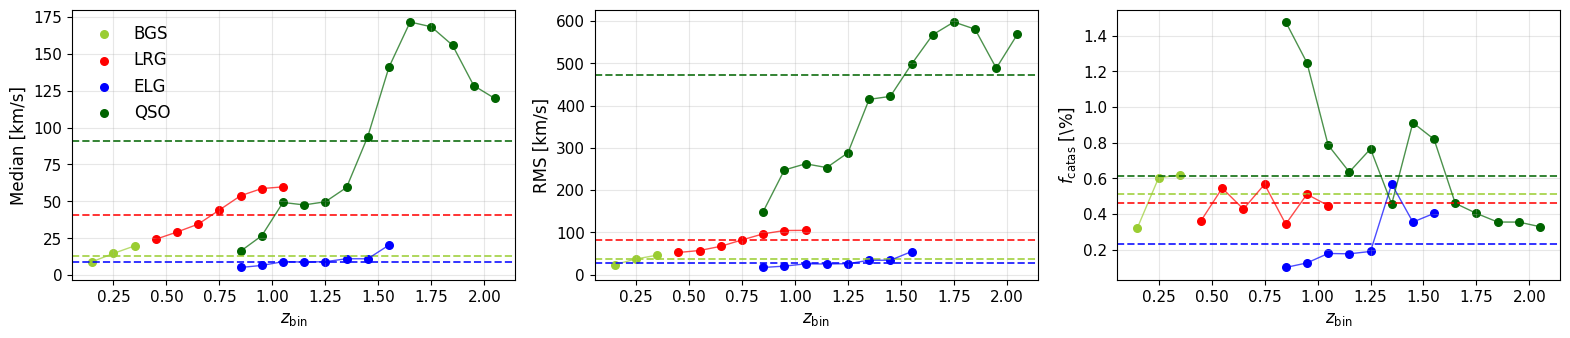

In [ ]:
tracers = ['BGS','LRG', 'ELG', 'QSO']
step = 0.1

OVERALL_VALUES = {
    'BGS': {'median': 13.3, 'rms': 36.0, 'fc': 0.51},
    'LRG': {'median': 40.7, 'rms': 82.1, 'fc': 0.46},
    'ELG': {'median': 8.6, 'rms': 28.2, 'fc': 0.23},
    'QSO': {'median': 91.0, 'rms': 471.2, 'fc': 0.61}
}

fig = plt.figure(figsize=(16, 3))
gs = gridspec.GridSpec(1,3,wspace=0.18,hspace=0.1,left=0.05, right=0.98, top=0.95, bottom=0.05)
for tracer in tracers:
    (zmin, zmax) = REDSHIFT_OVERALL[tracer]
    zrange = np.round(np.arange(zmin, zmax+ step/2, step), 1)
    zbins = list(zip(zrange[:-1], zrange[1:]))
    color = COLOR_OVERALL[tracer]
    zmid_list, median_list, rms_list, fc_list = [], [], [], []
    for indz, (z1, z2) in enumerate(zbins):
        dv = generate_dv(tracer, z1, z2)
        # ===== quantities of dv =====
        catas_threshold = 10000 if tracer == 'QSO' else 1000
        dv_smear = dv[abs(dv) < catas_threshold]
        median_dv = np.median(abs(dv))
        RMS = np.sqrt(np.mean(dv_smear**2))    
        fc = (np.sum(abs(dv) > catas_threshold)) /len(dv)
        zmid_list.append((z1 + z2) / 2)
        median_list.append(median_dv) # in km/s
        rms_list.append(RMS) # in km/s
        fc_list.append(fc*100) # in %
    # === Plot panels ===
    for idxq, (ydata, ylabel, ykey) in enumerate(
        zip(
            [median_list, rms_list, fc_list],
            [r"Median [km/s]", r"RMS [km/s]", r"$f_{\mathrm{catas}}$ [\%]"],
            ['median', 'rms', 'fc'],
        )
    ):
        ax = plt.subplot(gs[idxq])
        ax.scatter(zmid_list, ydata, color=color, s=30, label=tracer)
        ax.plot(zmid_list, ydata, color=color, lw=1.0, alpha=0.7)
        # === add horizontal line for global value ===
        yvalue = OVERALL_VALUES[tracer][ykey]
        ax.axhline(y=yvalue, color=color, linestyle='--', lw=1.4, alpha=0.8)
        # plot axes settings
        ax.set_xlabel(r"$z_{\mathrm{bin}}$", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(alpha=0.3)
        if idxq==0:
            ax.legend(fontsize=12, loc='best', frameon=False)

# if save_fig == True:
    # plt.savefig(overleaf_dir+f'/scatter_z_dependence', dpi=300, bbox_inches='tight')

In [ ]:
def bootstrap_metrics(dv, cthr, B=1000, seed=1234):
    """
    Estimate median(|dv|), RMS(core), and fc using bootstrap resampling.

    Parameters
    ----------
    dv : array Δv values (km/s) for one tracer or z-bin
    cthr : float Catastrophic threshold (e.g., 1000 or 10000 km/s)
    B : int Number of bootstrap resamples

    Returns
    -------
    dict with medians and 16-84% confidence intervals.
    """
    rng = np.random.default_rng(seed)
    dv_abs = np.abs(dv)
    N = len(dv_abs)

    med, rms, fc = np.empty(B), np.empty(B), np.empty(B)
    for b in range(B):
        idx = rng.integers(0, N, N)
        x = dv_abs[idx]
        core = x[x < cthr]
        med[b] = np.median(x)
        rms[b] = np.sqrt(np.mean(core**2)) if core.size else np.nan
        fc[b]  = np.mean(x >= cthr)*100
    out = {
        'median': {'mean': np.nanmean(med), 'std': np.nanstd(med, ddof=1)},
        'rms':    {'mean': np.nanmean(rms), 'std': np.nanstd(rms, ddof=1)},
        'fc':     {'mean': np.nanmedian(fc),  'std': np.nanstd(fc, ddof=1)}
    }
    return out

def jackknife_metrics(dv, cthr):
    """
    Delete-1 jackknife variance for median(|dv|), RMS(core), and fc.

    Parameters
    ----------
    dv : array Δv values (km/s)
    cthr : float Catastrophic threshold (km/s)

    Returns
    -------
    dict with mean and ±1σ jackknife errors.
    """
    dv_abs = np.abs(dv)
    N = len(dv_abs)
    if N <= 1:
        return {k:(np.nan,(np.nan,np.nan)) for k in ['median','rms','fc']}
    med, rms, fc = np.empty(N), np.empty(N), np.empty(N)

    med_loo = loo_medians_fast(dv_abs) # sort once and no need for loop
    for i in range(N):
        x = np.delete(dv_abs, i)
        core = x[x < cthr]
        # med[i] = np.median(x) # use the function loo_medians_fast without loop
        rms[i] = np.sqrt(np.mean(core**2)) if core.size else np.nan
        fc[i]  = np.mean(x >= cthr)*100
    def jk_std(arr):
        G = len(arr)
        mean = np.nanmean(arr)
        var = (G - 1) / G * np.nansum((arr - mean)**2)
        return np.sqrt(var)
    med_mean, rms_mean, fc_mean = map(np.nanmean, [med_loo, rms, fc])
    med_err,  rms_err,  fc_err  = map(jk_std, [med, rms, fc])
    out = {
        'median': {'mean': med_mean, 'std': med_err},
        'rms':    {'mean': rms_mean, 'std': rms_err},
        'fc':     {'mean': fc_mean,  'std': fc_err}
    }
    return out

def loo_medians_fast(a):
    """
    Return the N delete-1 medians of array a in O(N log N).
    """
    a = np.asarray(a)
    N  = a.size
    # Sort once and map each element to its rank
    order = np.argsort(a, kind='mergesort')   # stable; any kind works here
    y     = a[order]                          # sorted values
    rank  = np.empty(N, dtype=int)
    rank[order] = np.arange(N)
    if N % 2 == 0:
        # N = 2k → N-1 odd → median is element at index k-1 of y' (y with one removed)
        k = N // 2
        # If you remove something left of k, the (k-1)th of y' is y[k]; else it's y[k-1]
        med_loo = np.where(rank < k, y[k], y[k-1]).astype(float)
    else:
        # N = 2k+1 → N-1 even → median is average of indices (k-1, k) in y'
        k = N // 2
        left  = (y[k-1] + y[k])   * 0.5      # remove right side (r ≥ k+1)
        mid   = (y[k-1] + y[k+1]) * 0.5      # remove one of the middle pair (r == k)
        right = (y[k]   + y[k+1]) * 0.5      # remove left side (r ≤ k-1)
        med_loo = np.empty(N, dtype=float)
        med_loo[rank <= k-1] = right
        med_loo[rank == k]   = mid
        med_loo[rank >= k+1] = left
    return med_loo

In [ ]:
dv_abs = np.abs(dv)
N = len(dv_abs)
med, rms, fc = np.empty(N), np.empty(N), np.empty(N)
med_loo = loo_medians_fast(dv_abs) # sort once and no need for loop
for i in range(N):
    x = np.delete(dv_abs, i)
    core = x[x < 1000]
    med[i] = np.median(x)

In [ ]:
set(med_loo==med)

{True}

In [ ]:
%load_ext line_profiler
%lprun -f jackknife_metrics jackknife_metrics(dv, 1000)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 10.4734 s
File: /tmp/ipykernel_654628/3796803354.py
Function: jackknife_metrics at line 37

Line #      Hits         Time  Per Hit   % Time  Line Contents
    37                                           def jackknife_metrics(dv, cthr):
    38                                               """
    39                                               Delete-1 jackknife variance for median(|dv|), RMS(core), and fc.
    40                                           
    41                                               Parameters
    42                                               ----------
    43                                               dv : array Δv values (km/s)
    44                                               cthr : float Catastrophic threshold (km/s)
    45                                           
    46                                               Returns
    47                                               -------
    48                      

In [ ]:
np.median(np.c_[np.array_split(dv, 30)[:-9]], axis=0)